In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from keras.callbacks import ReduceLROnPlateau


def quantile_loss(i):
  def loss(y_true, y_pred):
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(i * e, (i - 1) * e))
  return loss

X = pd.read_csv("Xtable.csv")
y= X.iloc[:,-1].values
X = X.iloc[:,1:].values

window_size = 50;
step_size = 15;

X_win_all = []
y_win_all = []

for i in range(0,len(X)-window_size-15+1,step_size):
  X_win = X[i:i+window_size]
  y_win = y[i+window_size:i+window_size+15]
  X_win_all.append(X_win)
  y_win_all.append(y_win)

X_win_all=np.array(X_win_all)
y_win_all=np.array(y_win_all)

# Although called val, all variables with val is for testing, because we train a model from scratch in every walk
X_trainval = X_win_all[:]
y_trainval = y_win_all[:]

# Walk forward Validation
shift_win = 1

# In a single walk
n_train = 10
n_valid = 1

pred_train_all = []
pred_val_all = []

true_train_all = []
true_val_all = []

rmse_train_per_walk = []
rmse_val_per_walk = []

train_idx_all = []
val_idx_all = []

hist_tr_loss = []

# Coloumns to be normalized
cols_N = np.concatenate([np.arange(8,37),np.array([38,39,41,42,44,45,47,48,50,51,53,54,56,57,58])])

for start_idx in range(0, len(X_trainval)-n_train-n_valid+1,shift_win):

  X_train = X_trainval[start_idx:start_idx+n_train].copy()
  y_train = y_trainval[start_idx:start_idx+n_train].copy()

  X_val = X_trainval[start_idx+n_train:start_idx+n_train+n_valid]
  y_val = y_trainval[start_idx+n_train:start_idx+n_train+n_valid]

  # Normalization
  normalizer_y =StandardScaler()
  normalizer_X = {}

  for k in cols_N:
    scaler_X = StandardScaler()
    X_train[:,:,k] = scaler_X.fit_transform(X_train[:,:,k])
    normalizer_X[k] = scaler_X

  normalizer_y.fit_transform(y_train.flatten().reshape(-1,1))
  y_train = normalizer_y.transform(y_train.flatten().reshape(-1,1)).reshape(-1,15)

  for k in cols_N:
    X_val[:,:,k] = normalizer_X[k].transform(X_val[:,:,k])

  y_val = normalizer_y.transform(y_val.flatten().reshape(-1, 1)).reshape(-1, 15)

 # fitting

  mdl = Sequential([
      LSTM(
        units=150,
        input_shape=[window_size,X_train.shape[2]],
        activation='tanh',
        return_sequences=True,
      ),
      LSTM(
        units=150,
        input_shape=[window_size,X_train.shape[2]],
        activation='tanh',
      ),
      Dropout(0.2),
      Dense(15)
  ])

  mdl.compile(optimizer=Adam(learning_rate=0.01),loss=Huber(delta=1))

  hist = mdl.fit(X_train,
                 y_train,
                 epochs=15,
                 shuffle=False,
                 batch_size=20)

  hist_tr_loss.append(hist.history['loss'])

  train_pred = mdl.predict(X_train)
  val_pred  = mdl.predict(X_val)

  train_pred = normalizer_y.inverse_transform(train_pred)
  val_pred = normalizer_y.inverse_transform(val_pred)

  true_train = normalizer_y.inverse_transform(y_train)
  true_val = normalizer_y.inverse_transform(y_val)

  pred_train_all.append(train_pred)
  pred_val_all.append(val_pred)

  true_train_all.append(true_train)
  true_val_all.append(true_val)

  time_idx = start_idx * step_size + window_size
  train_idx = list(range(time_idx, time_idx + n_train * 15))
  val_idx = list(range(time_idx + n_train * 15, time_idx + (n_train + n_valid) * 15))

  train_idx_all.append(train_idx)
  val_idx_all.append(val_idx)

  rmse_train_per_walk.append(np.sqrt(mean_squared_error(train_pred,true_train)))
  rmse_val_per_walk.append(np.sqrt(mean_squared_error(val_pred,true_val)))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.3618
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1845
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.3053
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1528
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1406
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1153
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0972
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0691
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0496
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0341
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.0484
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0449
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0394
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0449
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.0343
1/1 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3807
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1456
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.6530
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.2067
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0807
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0685
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0698
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0456
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0491
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0593
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0458
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0618
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0465
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0344
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0317
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4653
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step - loss: 0.1770
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step - loss: 0.5093
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.3006
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.1275
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1353
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0868
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0866
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0644
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0705
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0545
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0663
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0582
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0479
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0461


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
RMSE Before Residuals: 170.81794212312954
RMSE After Residuals: 170.81794212312954
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4583
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2307
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.7657
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.3083
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1223
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1142
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0745
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.0810
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0542
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0553
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0625
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0559
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0617
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0386
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0430
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4722
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2339
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.5444
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.3091
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2023
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1622
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1737
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1310
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1011
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0738
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0697
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0694
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0531
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0531
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0446
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5085
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2345
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.4130
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2815
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2098
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1774
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1648
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.1339
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0975
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.0680
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.2833
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.0688
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.1136
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.1132
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.0789
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4388
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.3492
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.6180
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.3608
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2326
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2000
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1978
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1624
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.1360
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1455
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1208
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.1029
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1069
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0946
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4341
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.3346
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.4193
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.3488
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.2730
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.2000
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.2094
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 0.1727
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1405
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1031
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0827
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1419
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1257
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0950
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0608
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4414
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.3151
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.7984
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.3547
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2861
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1877
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1110
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.1008
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1352
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1121
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0770
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1085
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0929
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0774
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0679
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.4795
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2407
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.4937
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.6053
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1693
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1656
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1638
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1372
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.1295
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0979
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0950
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0719
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0764
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0502
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0591
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4688
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2000
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.5537
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1942
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.1210
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1038
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0806
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0728
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0658
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0635
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0641
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0471
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - loss: 0.0453
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0399
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.0381
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5175
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1948
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.7622
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2582
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1702
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1276
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1052
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0632
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0777
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0586
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0559
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0439
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0518
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0465
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4258
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.2787
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.6322
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.2789
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 0.1763
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.1063
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0797
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.0695
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 0.0819
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.0614
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.0553
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.0592
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.0660
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0560
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0425
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4325
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.2827
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.4780
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2209
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.1308
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1230
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0911
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0915
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0534
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0657
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0459
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0523
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0635
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0577
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4512
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.1812
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.4448
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.2236
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1082
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1910
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 0.1829
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1498
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1174
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0890
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0885
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.0802
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0584
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0596
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0494
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4578
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1650
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.3491
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2653
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.2324
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1532
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1303
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1304
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1043
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1934
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.0679
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - loss: 0.0579
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0533
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 0.0469
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.0505
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4225
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1490
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2890
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1561
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1479
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1356
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1495
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.1220
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0882
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0728
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0481
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 0.1345
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0837
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0478
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0692
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4523
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.1993
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.3173
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.4849
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.2213
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.1398
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.1187
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.0925
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.1123
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.0670
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.0565
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0691
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0465
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.0506
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.0434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4822
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1940
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.7360
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2757
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1488
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1049
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 0.0845
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0867
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0705
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0717
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0582
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0450
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0508
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0526
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0384
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4882
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.1628
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.5570
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.2598
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.1296
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.1098
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0832
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0784
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0764
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0554
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0500
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0531
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0385
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0377
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0412
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4859
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1480
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.7997
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2411
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.2833
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.2167
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1657
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1477
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1530
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1501
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0741
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.1443
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.1232
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1098
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1082
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.4943
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2596
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.3433
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2089
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1094
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0794
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0818
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0864
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.0899
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0525
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0452
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0401
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0442
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0544
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0370
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4696
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.1707
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.5552
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2265
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.3546
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2720
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.2074
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1285
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1139
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0706
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0730
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 0.0716
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.0447
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.0500
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.0523
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4060
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2261
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.2538
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.3375
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1279
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1105
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0729
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0695
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0667
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0557
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0491
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0389
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0402
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0318
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0328
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4358
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.3272
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.3705
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.2198
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.2673
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.1590
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.1544
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0900
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 0.0732
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.0711
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.0538
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.0629
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.0487
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.0406
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.0376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4559
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.3377
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.5142
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2718
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.2551
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1816
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1087
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0859
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0640
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0617
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0470
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0670
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0559
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0437
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4309
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.3765
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.3909
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.2299
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1880
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1199
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0984
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0721
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0787
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0613
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0589
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0463
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0481
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0385
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0349
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4227
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.2725
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2885
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2425
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1659
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1736
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1505
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0942
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0623
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0535
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0705
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0639
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0459
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0449
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0421
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.3938
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2275
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.5108
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1843
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1483
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1067
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0940
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1107
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0767
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0804
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0672
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0444
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0485
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0399
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0361
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4451
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.1884
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2557
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1063
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1371
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0727
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0908
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.0880
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.0599
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.0539
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.0522
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0358
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.0487
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.0397
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.0393
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4496
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1333
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.2312
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.3900
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1834
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1081
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0935
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1275
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0915
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0601
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0534
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0540
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0437
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0396
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4906
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.1251
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.4148
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.2066
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.1018
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.1012
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.0781
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.0846
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.0621
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0552
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0361
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0397
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0349
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0349
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4728
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1189
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.3322
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1360
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0744
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0715
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0711
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0608
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0527
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0467
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0394
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0433
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0393
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0340
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0252
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4535
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1692
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.7476
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2438
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.1539
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1142
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.1182
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0834
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0808
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0615
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0566
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0576
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0566
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0623
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.0364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4605
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.2198
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.2280
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3549
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1147
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0735
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0658
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0641
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0804
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0683
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0409
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0396
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0305
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0341
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0326
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3882
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.2303
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.2929
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1052
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1441
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0766
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0892
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1430
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0557
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0878
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0538
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0413
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0418
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0421
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0352
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4123
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.3261
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.3233
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.3079
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1646
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1629
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1424
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.1057
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0712
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0633
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0498
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0432
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0465
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0302
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.0368
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4133
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.3045
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.3301
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.4473
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1959
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1418
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1057
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.0553
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0905
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0414
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0526
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0426
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0398
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0306
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0261
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4448
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.3249
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.4053
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.2156
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.1519
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.1512
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.1047
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0961
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0957
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0530
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0597
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.0535
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0526
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0403
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0323
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4683
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2476
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.4039
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2479
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2343
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1934
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1259
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1201
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0936
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0969
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0496
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0570
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0456
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0446
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0494
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4331
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1586
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.3873
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.3175
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1998
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.1396
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1341
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1161
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0987
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0656
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0544
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0405
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0436
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0408
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0354
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4503
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.1952
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.4880
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.3087
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1523
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1136
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0757
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0591
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0573
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0674
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0443
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0392
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0447
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.0349
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0369
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5053
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.2088
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.3590
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1550
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.1339
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1103
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0923
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0940
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0611
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0491
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0682
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0612
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0518
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0534
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4869
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1712
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1737
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.1536
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1917
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0956
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.0680
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0839
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.0683
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0537
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.0425
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0507
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0434
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0381
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.0356
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4535
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1467
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2494
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2737
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1581
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1031
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0821
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0896
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0635
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0504
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0436
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0540
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0355
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0349
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0332
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4464
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.1962
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.4712
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.2286
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.1524
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.1386
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.1038
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.0894
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.0933
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0551
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.0534
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0603
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0440
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0423
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0412
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4731
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2252
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.4588
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1914
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.1530
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0980
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0936
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0859
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0842
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0781
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0653
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0538
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0617
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0429
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0374
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.4518
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2496
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.3203
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2232
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1632
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1224
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0945
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0890
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0761
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0540
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0537
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0453
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0730
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0439
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.0307
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4433
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.2121
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - loss: 0.3622
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step - loss: 0.3023
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step - loss: 0.1718
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 0.1206
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step - loss: 0.0709
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.0651
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0646
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0462
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.0465
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.0384
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0381
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0505
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0388
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4313
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.2139
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.3480
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2115
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.1707
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1178
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0930
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0764
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0585
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0471
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0585
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0456
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0445
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0376
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0383
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4870
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2254
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.2483
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.4905
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2051
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1701
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.1245
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0892
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0884
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0713
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0786
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0585
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.0572
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0533
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0451
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4714
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2581
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.3285
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2210
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1657
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0758
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0697
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0695
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0521
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0435
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0514
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.0421
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.0316
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.0393
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4641
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2485
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.3589
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.3012
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.2413
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1612
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0991
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.0754
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0665
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0686
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0625
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.0524
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0498
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0441
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0464
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4076
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 0.2362
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.4346
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.2583
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.1599
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 0.1567
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.0901
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0762
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.0662
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0581
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0477
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0532
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0386
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0462
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0382
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4709
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.2522
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1808
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.2270
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1758
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1146
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0776
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0657
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0559
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0541
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0493
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0390
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0376
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0445
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0380
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4077
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2685
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.4689
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2825
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1833
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1599
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.0733
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0652
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0622
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0725
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1259
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0676
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0800
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0556
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0491
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms

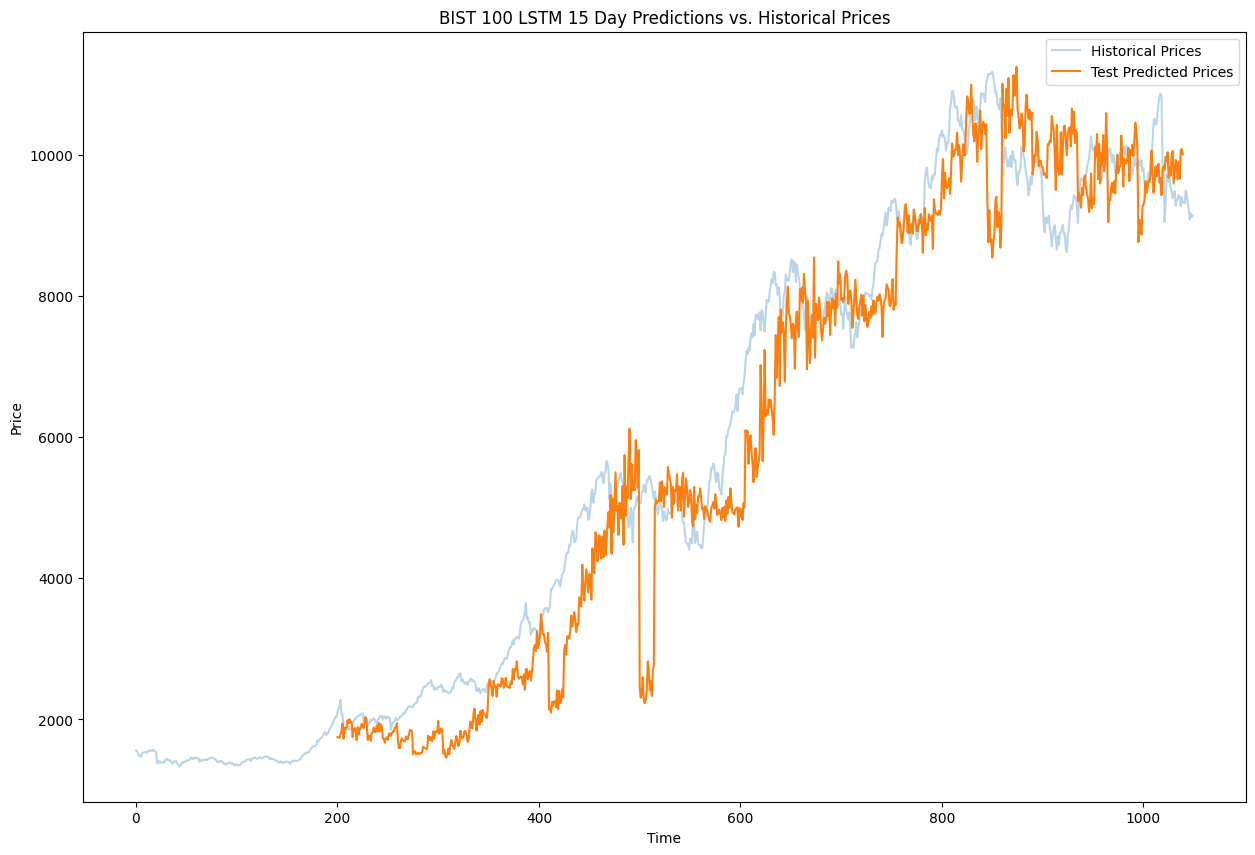

In [ ]:
plt.figure(figsize=(15,10))
pred_val_all_flat = np.concatenate([p.flatten() for p in pred_val_all])
true_val_all_flat = np.concatenate([p.flatten() for p in true_val_all])
res = true_val_all_flat.reshape(-1,1) - pred_val_all_flat.reshape(-1,1)

val_idx_all_flat = np.concatenate([p.flatten() for p in np.array(val_idx_all)])

plt.plot(range(len(y)),y, label='Historical Prices', alpha=0.3)
plt.plot(val_idx_all_flat, pred_val_all_flat, label='Test Predicted Prices')

plt.title('BIST 100 LSTM 15 Day Predictions vs. Historical Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
pred_err_val = []
true_err_val = []

for i in range(len(pred_val_all)):
  idx = [idx for idx in val_idx_all[i] if idx < len(y)]
  pred_err_val.extend(pred_val_all[i].flatten()[:len(idx)])
  true_err_val.extend(y[idx])

rmse_val_err = np.sqrt(mean_squared_error(pred_err_val,true_err_val))
r2_val_err = r2_score(pred_err_val,true_err_val)
mae_val_err = mean_absolute_error(pred_err_val,true_err_val)
mape_val_err = mean_absolute_percentage_error(pred_err_val,true_err_val)
acc_val_err = (1-mae_val_err/np.mean(true_err_val))*100

pred_err_train = []
true_err_train = []

for i in range(len(pred_train_all)):
  idx = [idx for idx in train_idx_all[i] if idx < len(y)]
  pred_err_train.extend(pred_train_all[i].flatten()[:len(idx)])
  true_err_train.extend(y[idx])

rmse_train_err = np.sqrt(mean_squared_error(pred_err_train,true_err_train))
r2_train_err = r2_score(pred_err_train,true_err_train)
mae_train_err = mean_absolute_error(pred_err_train,true_err_train)
mape_train_err = mean_absolute_percentage_error(pred_err_train,true_err_train)
acc_train_err = (1-mae_train_err/np.mean(true_err_train))*100

print(f"TRAIN RMSE: {rmse_train_err}")
print(f"TRAIN R2: {r2_train_err}")
print(f"TRAIN MAE: {mae_train_err}")
print(f"TRAIN MAPE: {mape_train_err}")
print(f"TRAIN ACC: {acc_train_err}")

print(f"TEST RMSE: {rmse_val_err}")
print(f"TEST R2: {r2_val_err}")
print(f"TEST MAE: {mae_val_err}")
print(f"TEST MAPE: {mape_val_err}")
print(f"TEST ACC: {acc_val_err}")

TRAIN RMSE: 153.1646239686778
TRAIN R2: 0.9975872877460942
TRAIN MAE: 104.8250685407366
TRAIN MAPE: 0.02242787056858104
TRAIN ACC: 98.17837149804429
TEST RMSE: 883.9749350218117
TEST R2: 0.9236964352383932
TEST MAE: 668.7183543178014
TEST MAPE: 0.16412837309394385
TEST ACC: 89.80812980089372


In [ ]:
pred_val_all_flat = np.concatenate([p.flatten() for p in pred_val_all])
true_val_all_flat = np.concatenate([p.flatten() for p in true_val_all])
res = true_val_all_flat.reshape(-1,1) - pred_val_all_flat.reshape(-1,1)

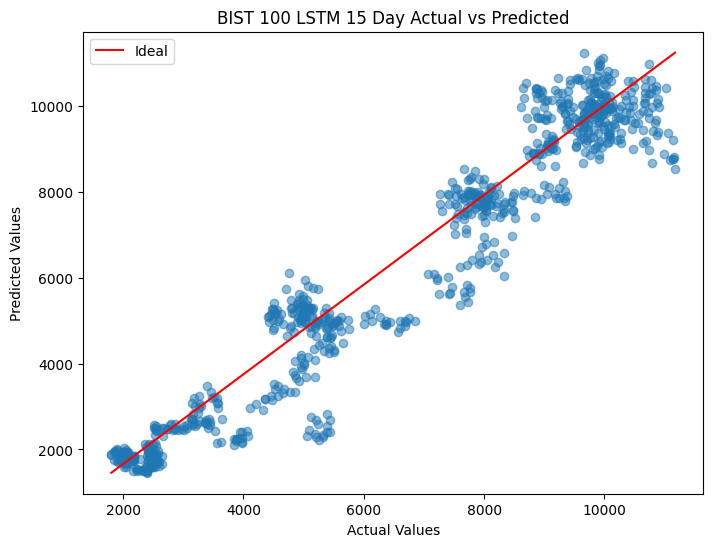

In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(true_val_all_flat, pred_val_all_flat, alpha=0.5)
plt.plot([min(true_val_all_flat),max(true_val_all_flat)],[min(pred_val_all_flat),max(pred_val_all_flat)],"r", label="Ideal")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("BIST 100 LSTM 15 Day Actual vs Predicted")
plt.legend()
plt.show()

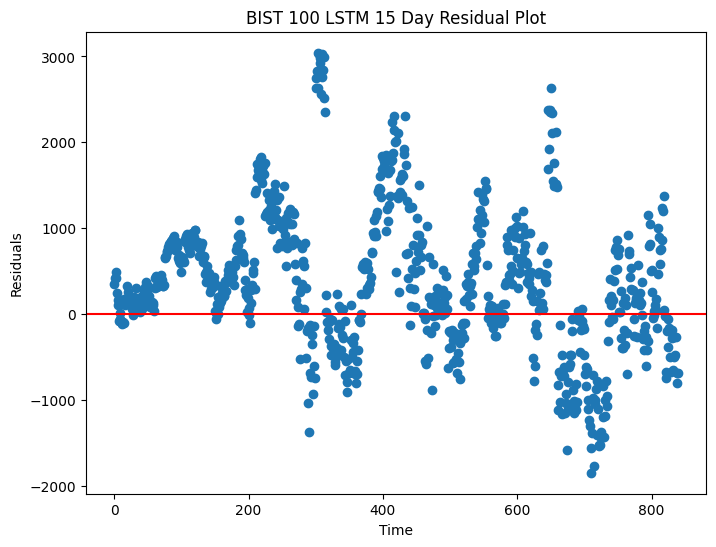

In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(range(len(res)),res)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("BIST 100 LSTM 15 Day Residual Plot")
plt.show()

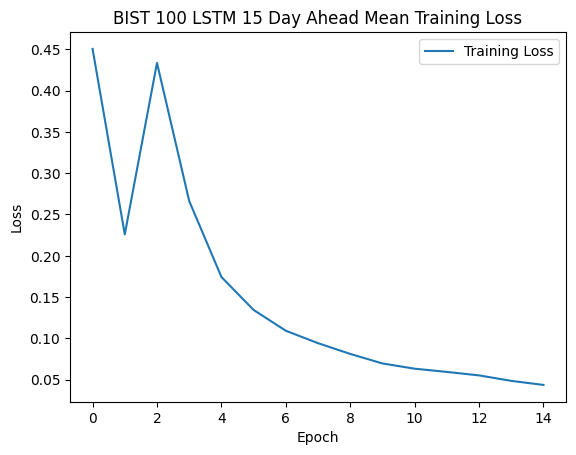

In [ ]:
hist_tr_loss = np.array(hist_tr_loss)

hist_tr_loss_mean = np.mean(hist_tr_loss, axis=0)

plt.plot(hist_tr_loss_mean, label='Training Loss')
plt.title('BIST 100 LSTM 15 Day Ahead Mean Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

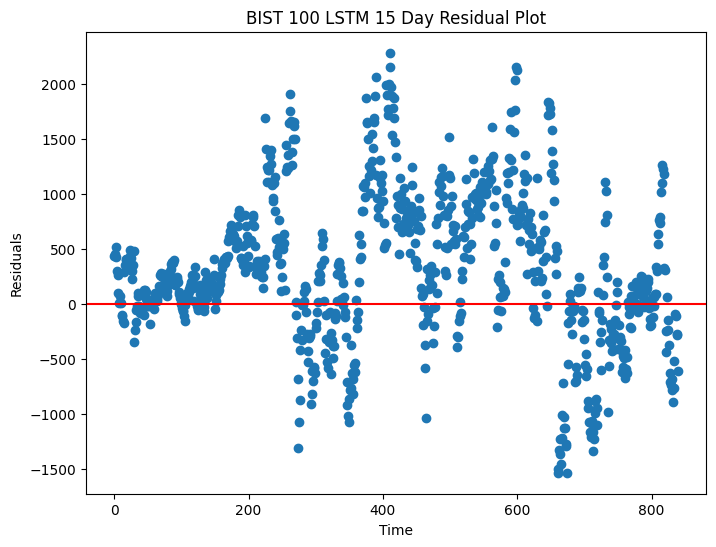

In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(range(len(res_savgol)),res_savgol)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("BIST 100 LSTM 15 Day Residual Plot")
plt.show()